We will train two different models. One cnn will use the written digit training data to predict the label, while the other, an rnn, will use the spoken audio data to do the same. To make our final predictions, we will use the model which exhibits the highest confidence for each guess. We will procede first by training the cnn: 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import f1_score

<Axes: >

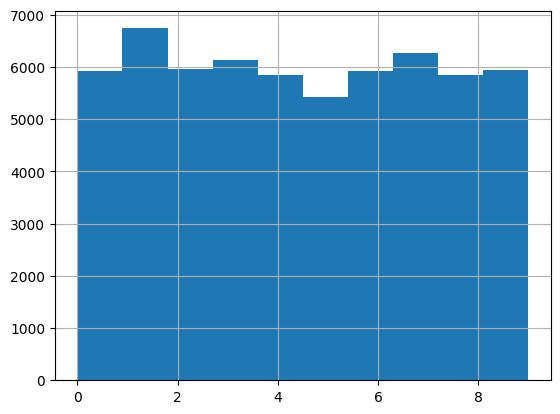

In [4]:
#get labels, explore distribution
training_labels = pd.read_csv("data/y_train.csv")["label"]
training_labels.hist()

In [5]:
#custom dataset wrapper
class CustomDataset(Dataset):
    def __init__(self, data_file, labels_file=None, is_test=False):
        self.data = np.load(data_file)
        if not is_test:
            self.labels = pd.read_csv(labels_file)["label"]
        else:
            self.labels = None
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if self.labels is not None:
            sample = {
                'data': torch.tensor(self.data[idx].reshape(1, 28, 28), dtype=torch.float),
                'label': torch.tensor(self.labels[idx], dtype=torch.long)
            }
        else:
            sample = {
                'data': torch.tensor(self.data[idx].reshape(1, 28, 28), dtype=torch.float)
            }
        return sample


def get_data_loaders(data_file, labels_file, batch_size=64, validation_size=0.2):
    dataset = CustomDataset(data_file, labels_file)
    
    #split dataset into training and validation sets
    train_indices, val_indices = train_test_split(
        np.arange(len(dataset)),
        test_size=validation_size,
        random_state=21,
        stratify=dataset.labels  
    )
    
    train_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        sampler=torch.utils.data.SubsetRandomSampler(train_indices)
    )
    
    val_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        sampler=torch.utils.data.SubsetRandomSampler(val_indices)
    )
    
    return train_loader, val_loader

In [6]:
img_dataset = CustomDataset("data/x_train_wr.npy", "data/y_train.csv")

In [7]:
#custom cnn implementation
#CNN implementation

class cnn_block(nn.Module):
  def __init__(self, in_channels = 3, n_hidden = 5, kernel_size = (2, 2)):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Conv2d(in_channels       = in_channels, out_channels = n_hidden, kernel_size = kernel_size, bias=False, padding = 'same'),
        nn.BatchNorm2d(num_features = n_hidden),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        nn.Conv2d(in_channels       = n_hidden, out_channels = in_channels, kernel_size = kernel_size, bias=False, padding = 'same'),
        nn.BatchNorm2d(num_features = in_channels),
        nn.ReLU(),
        nn.Dropout(p=0.2))

  def forward(self, x):
    return x + self.layers(x)


class linear_block(nn.Module):
  def __init__(self, in_features, n_hidden):
    super().__init__()
    self.in_features = (in_features, n_hidden)
    self.layers = nn.Sequential(
        nn.Linear(in_features = in_features, out_features = n_hidden),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        nn.Linear(in_features = n_hidden, out_features = in_features),
        nn.ReLU()
    )

  def forward(self, x):
    return x + self.layers(x)

class CNNClassifier(nn.Module):
  def __init__(self, in_channels = 1, cnn_channels = 1, linear_hidden = 500, n_classes = 10, kernel_size = (3, 3)):
    super().__init__()

    
    self.cnn_layers = nn.Sequential(
        cnn_block(in_channels, cnn_channels, kernel_size),
        cnn_block(in_channels, cnn_channels, kernel_size),
        cnn_block(in_channels, cnn_channels, kernel_size))


    self.down_sample = nn.Conv2d(in_channels = in_channels, out_channels = 1, kernel_size = (1, 1))

    self.linear_layers = nn.Sequential(
        linear_block(28*28, linear_hidden),
        linear_block(28*28, linear_hidden)
    )
    self.last_layer = nn.Linear(28*28, n_classes)

    self.all        = nn.Sequential(
        self.cnn_layers,
        self.down_sample,
        nn.Flatten(),
        self.linear_layers,
        self.last_layer,
    )

  def forward(self, x):
    return self.all(x)

In [8]:
#train cnn

#training 
def train_cnn(model, train_loader, val_loader, optimizer, criterion, epochs=5, device='cpu'):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        val_loss = 0.0
        correct = 0
        total = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/ {epochs}", unit="batch"):
            inputs, labels = batch['data'].to(device), batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss /= len(train_loader)
        train_acc = correct / total

        # Validation loop
        model.eval()
        with torch.no_grad():
            for batch in val_loader:
                inputs, labels = batch['data'].to(device), batch['label'].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Validation Loss: {val_loss:.4f}")


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def validate(model, val_loader):
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch['data'].to(device), batch['label'].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    f1 = f1_score(true_labels, predicted_labels, average='macro')
    return f1

In [10]:
#split the data into training and validation sets with 80-20 split
batch_size = 64
validation_size = 0.2
train_loader, val_loader = get_data_loaders("data/x_train_wr.npy", "data/y_train.csv", batch_size=batch_size, validation_size=validation_size)

The next portion of the code tries out different hyperparams by training different models on a small subset of the training data (1/5 of the training data) for only 3 epochs. It takes a bit to run, but after expirementing, {'cnn_channels': 3, 'linear_hidden': 25, 'kernel_size': (5, 5)} TENDS to work the best (although other hyperparams are close) with an F1 score of roughly .94 (which is pretty good considering it's only training on a small subset of the total data). If you want to check my hyperparam comparision, you can simply change the variable below to True to run this process. Otherwise, we simply default to the previously described hyperparams.

In [11]:
waste_a_lot_of_time = False

In [12]:
#get a smaller dataset for hyperparam comparisons 
hyper_loader, hyper_val_loader = get_data_loaders("data/x_train_wr.npy", "data/y_train.csv", batch_size=batch_size, validation_size=.8) #thus we train on .2 of given data

In [14]:
#test different hyperparams 

hyperparameters = {
    'cnn_channels': [2, 3],  # Vary the number of channels in the CNN layers
    'linear_hidden': [25, 50],  # Vary the number of hidden units in linear layers
    'kernel_size': [(3, 3), (5, 5)]  # Vary the kernel size of the convolutional layers
}

# Perform hyperparameter tuning
best_f1 = 0.0
best_hyperparameters = {}
if (waste_a_lot_of_time):
    for cnn_channels in hyperparameters['cnn_channels']:
        for linear_hidden in hyperparameters['linear_hidden']:
            for kernel_size in hyperparameters['kernel_size']:
                print(f"Training model: cnn_channels={cnn_channels}, linear_hidden={linear_hidden}, kernel_size={kernel_size}")
                model = CNNClassifier(cnn_channels=cnn_channels, linear_hidden=linear_hidden, kernel_size=kernel_size)
                optimizer = optim.Adam(model.parameters(), lr=0.001)
                criterion = nn.CrossEntropyLoss()
                train_cnn(model, hyper_loader, hyper_val_loader, optimizer, criterion, epochs=3)
                val_accuracy = validate(model, hyper_val_loader)
                print(f"Validation F1 for cnn_channels={cnn_channels}, linear_hidden={linear_hidden}, kernel_size={kernel_size}: {val_accuracy}")
                if val_accuracy > best_f1:
                    best_f1 = val_accuracy
                    best_hyperparameters = {'cnn_channels': cnn_channels, 'linear_hidden': linear_hidden, 'kernel_size': kernel_size}
else: 
    best_hyperparameters = {'cnn_channels': 3, 'linear_hidden': 25, 'kernel_size': (5, 5)}

print("Best Hyperparameters:", best_hyperparameters)
print("Best Validation Accuracy:", best_f1)

Training model: cnn_channels=2, linear_hidden=25, kernel_size=(3, 3)


Epoch 1/ 3:   0%|          | 0/188 [00:00<?, ?batch/s]

Epoch 1/ 3: 100%|██████████| 188/188 [00:05<00:00, 31.80batch/s]


Epoch 1/3, Train Loss: 1.8648, Train Accuracy: 0.3579, Validation Loss: 0.7279


Epoch 2/ 3: 100%|██████████| 188/188 [00:05<00:00, 35.44batch/s]


Epoch 2/3, Train Loss: 0.5623, Train Accuracy: 0.8304, Validation Loss: 0.4149


Epoch 3/ 3: 100%|██████████| 188/188 [00:05<00:00, 33.96batch/s]


Epoch 3/3, Train Loss: 0.4300, Train Accuracy: 0.8667, Validation Loss: 0.3484
Validation F1 for cnn_channels=2, linear_hidden=25, kernel_size=(3, 3): 0.8915425775747148
Training model: cnn_channels=2, linear_hidden=25, kernel_size=(5, 5)


Epoch 1/ 3: 100%|██████████| 188/188 [00:06<00:00, 30.36batch/s]


Epoch 1/3, Train Loss: 1.1627, Train Accuracy: 0.6142, Validation Loss: 0.3479


Epoch 2/ 3: 100%|██████████| 188/188 [00:05<00:00, 31.84batch/s]


Epoch 2/3, Train Loss: 0.3299, Train Accuracy: 0.8971, Validation Loss: 0.2352


Epoch 3/ 3: 100%|██████████| 188/188 [00:05<00:00, 32.10batch/s]


Epoch 3/3, Train Loss: 0.2512, Train Accuracy: 0.9197, Validation Loss: 0.1878
Validation F1 for cnn_channels=2, linear_hidden=25, kernel_size=(5, 5): 0.9445698893922014
Training model: cnn_channels=2, linear_hidden=50, kernel_size=(3, 3)


Epoch 1/ 3: 100%|██████████| 188/188 [00:05<00:00, 33.19batch/s]


Epoch 1/3, Train Loss: 0.7376, Train Accuracy: 0.7602, Validation Loss: 0.3659


Epoch 2/ 3: 100%|██████████| 188/188 [00:05<00:00, 36.15batch/s]


Epoch 2/3, Train Loss: 0.3812, Train Accuracy: 0.8813, Validation Loss: 0.2964


Epoch 3/ 3: 100%|██████████| 188/188 [00:04<00:00, 38.58batch/s]


Epoch 3/3, Train Loss: 0.3114, Train Accuracy: 0.9028, Validation Loss: 0.2367
Validation F1 for cnn_channels=2, linear_hidden=50, kernel_size=(3, 3): 0.9298038858371621
Training model: cnn_channels=2, linear_hidden=50, kernel_size=(5, 5)


Epoch 1/ 3: 100%|██████████| 188/188 [00:05<00:00, 31.93batch/s]


Epoch 1/3, Train Loss: 0.6928, Train Accuracy: 0.7765, Validation Loss: 0.3062


Epoch 2/ 3: 100%|██████████| 188/188 [00:05<00:00, 31.76batch/s]


Epoch 2/3, Train Loss: 0.3165, Train Accuracy: 0.9007, Validation Loss: 0.2350


Epoch 3/ 3: 100%|██████████| 188/188 [00:06<00:00, 28.98batch/s]


Epoch 3/3, Train Loss: 0.2501, Train Accuracy: 0.9213, Validation Loss: 0.1718
Validation F1 for cnn_channels=2, linear_hidden=50, kernel_size=(5, 5): 0.9464691864656188
Training model: cnn_channels=3, linear_hidden=25, kernel_size=(3, 3)


Epoch 1/ 3: 100%|██████████| 188/188 [00:05<00:00, 36.32batch/s]


Epoch 1/3, Train Loss: 1.3285, Train Accuracy: 0.5817, Validation Loss: 0.5136


Epoch 2/ 3: 100%|██████████| 188/188 [00:05<00:00, 36.43batch/s]


Epoch 2/3, Train Loss: 0.4922, Train Accuracy: 0.8548, Validation Loss: 0.3992


Epoch 3/ 3: 100%|██████████| 188/188 [00:05<00:00, 34.76batch/s]


Epoch 3/3, Train Loss: 0.3993, Train Accuracy: 0.8802, Validation Loss: 0.3432
Validation F1 for cnn_channels=3, linear_hidden=25, kernel_size=(3, 3): 0.8925440790068382
Training model: cnn_channels=3, linear_hidden=25, kernel_size=(5, 5)


Epoch 1/ 3: 100%|██████████| 188/188 [00:06<00:00, 28.73batch/s]


Epoch 1/3, Train Loss: 0.6239, Train Accuracy: 0.8040, Validation Loss: 0.2612


Epoch 2/ 3: 100%|██████████| 188/188 [00:06<00:00, 27.61batch/s]


Epoch 2/3, Train Loss: 0.2791, Train Accuracy: 0.9155, Validation Loss: 0.1944


Epoch 3/ 3: 100%|██████████| 188/188 [00:06<00:00, 29.12batch/s]


Epoch 3/3, Train Loss: 0.2170, Train Accuracy: 0.9349, Validation Loss: 0.1904
Validation F1 for cnn_channels=3, linear_hidden=25, kernel_size=(5, 5): 0.9416727401726026
Training model: cnn_channels=3, linear_hidden=50, kernel_size=(3, 3)


Epoch 1/ 3: 100%|██████████| 188/188 [00:05<00:00, 34.66batch/s]


Epoch 1/3, Train Loss: 0.9529, Train Accuracy: 0.6994, Validation Loss: 0.3799


Epoch 2/ 3: 100%|██████████| 188/188 [00:05<00:00, 34.76batch/s]


Epoch 2/3, Train Loss: 0.4083, Train Accuracy: 0.8755, Validation Loss: 0.3211


Epoch 3/ 3: 100%|██████████| 188/188 [00:05<00:00, 36.10batch/s]


Epoch 3/3, Train Loss: 0.3236, Train Accuracy: 0.9033, Validation Loss: 0.2616
Validation F1 for cnn_channels=3, linear_hidden=50, kernel_size=(3, 3): 0.9201871468026251
Training model: cnn_channels=3, linear_hidden=50, kernel_size=(5, 5)


Epoch 1/ 3: 100%|██████████| 188/188 [00:06<00:00, 28.52batch/s]


Epoch 1/3, Train Loss: 0.6594, Train Accuracy: 0.7903, Validation Loss: 0.2989


Epoch 2/ 3: 100%|██████████| 188/188 [00:06<00:00, 29.82batch/s]


Epoch 2/3, Train Loss: 0.3095, Train Accuracy: 0.9049, Validation Loss: 0.2299


Epoch 3/ 3: 100%|██████████| 188/188 [00:07<00:00, 26.67batch/s]


Epoch 3/3, Train Loss: 0.2518, Train Accuracy: 0.9220, Validation Loss: 0.2239
Validation F1 for cnn_channels=3, linear_hidden=50, kernel_size=(5, 5): 0.9306594066717102
Best Hyperparameters: {'cnn_channels': 2, 'linear_hidden': 50, 'kernel_size': (5, 5)}
Best Validation Accuracy: 0.9464691864656188


In [21]:
#train model with selected hyperparams
best_model = CNNClassifier(cnn_channels=best_hyperparameters['cnn_channels'], linear_hidden=best_hyperparameters['linear_hidden'], kernel_size=best_hyperparameters['kernel_size'])
optimizer = optim.Adam(best_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
train_cnn(best_model, train_loader, val_loader, optimizer, criterion)

Epoch 1/ 5:   0%|          | 0/750 [00:00<?, ?batch/s]

Epoch 1/ 5: 100%|██████████| 750/750 [00:26<00:00, 28.01batch/s]


Epoch 1/5, Train Loss: 0.3839, Train Accuracy: 0.8742, Validation Loss: 0.1875


Epoch 2/ 5: 100%|██████████| 750/750 [00:28<00:00, 26.65batch/s]


Epoch 2/5, Train Loss: 0.1834, Train Accuracy: 0.9421, Validation Loss: 0.1343


Epoch 3/ 5: 100%|██████████| 750/750 [00:28<00:00, 26.27batch/s]


Epoch 3/5, Train Loss: 0.1481, Train Accuracy: 0.9534, Validation Loss: 0.1068


Epoch 4/ 5: 100%|██████████| 750/750 [00:25<00:00, 29.98batch/s]


Epoch 4/5, Train Loss: 0.1237, Train Accuracy: 0.9604, Validation Loss: 0.0995


Epoch 5/ 5: 100%|██████████| 750/750 [00:24<00:00, 30.21batch/s]


Epoch 5/5, Train Loss: 0.1095, Train Accuracy: 0.9653, Validation Loss: 0.0896


In [ ]:

def get_test_loader(data_file, batch_size=64):
    test_dataset = CustomDataset(data_file, is_test=True)
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False 
    )
    return test_loader

test_data_loader = get_test_loader("data/x_test_wr.npy")

In [ ]:
#get predicted labels

best_model.eval()  # set the mode to eval
predicted_labels = []
confidence_scores = []

with torch.no_grad():
    for batch in test_data_loader:
        inputs = batch['data'].to(device)  
        outputs = best_model(inputs)
        probabilities = nn.functional.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        confidence_scores.extend(probabilities.gather(1, predicted.view(-1, 1)).squeeze().cpu().numpy()) #only add the highest confidence score, or the score of the predicted label

# Convert predictions to numpy array
predicted_labels = np.array(predicted_labels)
confidence_scores = np.array(confidence_scores)

In [ ]:
best_cnn_model = best_model

In [16]:
#now we will make a model that predicts the label based on the spoken audio

#get the data
audio_training_data = np.load("data/x_train_sp.npy")
print(audio_training_data.shape)

(60000, 507)


In [17]:
#define our model, we will use a simple RNN-style model to predict labels based on our audio


class RNNBlock(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=0):
        super(RNNBlock, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x shape: (batch_size, seq_length, input_size)
        out, _ = self.rnn(x)
        out = self.dropout(out)
        return out

class LinearBlock(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearBlock, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        out = self.linear(x)
        out = self.relu(out)
        out = self.dropout(out)
        return out
    
    
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, linear_hidden, num_classes):
        super(RNNClassifier, self).__init__()
        self.rnn_layers = RNNBlock(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
        self.linear_layers = nn.Sequential(
            LinearBlock(hidden_size, linear_hidden),  # Input size is now hidden_size
            LinearBlock(linear_hidden, linear_hidden)
        )
        self.output_layer = nn.Linear(linear_hidden, num_classes)

    def forward(self, x):
        out = self.rnn_layers(x)
        out = torch.mean(out, dim=1)  # Global average pooling over the sequence dimension
        out = self.linear_layers(out)
        out = self.output_layer(out)
        return out

In [19]:
print("Old shape:" + audio_training_data.shape)

#change the length of each sample from 507 to 520 (a more convenient size for our model) by padding each sample with 0s at the end
audio_training_data = np.pad(audio_training_data, ((0, 0), (0, 13)), mode='constant') 

#convert into tensors
audio_training_data_tens = torch.from_numpy(audio_training_data).float()
training_labels_tens = torch.from_numpy(np.array(training_labels)).long()

print("New shape: " + audio_training_data.shape)


(60000, 520)


In [20]:
rnn_model = RNNClassifier(520, 128, 2, 256, 10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=.01, momentum=.9)

num_epochs = 10
batch_size = 32

for epoch in range(num_epochs):
    running_loss = 0.0
    for i in range(0, len(audio_training_data_tens), batch_size):
        # Get mini-batch
        inputs = audio_training_data_tens[i:i+batch_size]
        target_labels = training_labels_tens[i:i+batch_size]
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = rnn_model(inputs)

        # Compute loss
        loss = criterion(outputs, target_labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 100 == 99:  # Print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x32 and 128x256)

In [ ]:
#save predictions
predictions_df = pd.DataFrame({'row_id': np.array([i for i in range(len(predicted_labels))]), 'label': predicted_labels.flatten()})
predictions_df.to_csv('Caleb Elizondo preds.csv', index=False)